In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Prerequisites: Load data

In [ ]:
# set up constants

BASE_GENRES = [
    "genre_blues",
    "genre_classical",
    "genre_country",
    "genre_disco",
    "genre_hiphop",
    "genre_jazz",
    "genre_metal",
    "genre_pop",
    "genre_reggae",
    "genre_rock"
]

STRATIFY = ['stratify']

KEY = ['metadata_path']

In [ ]:
# load base dataframe

import pandas as pd

filepath = "/content/drive/MyDrive/w207/mids_w207_music_genre/member_workspaces/lawrence/mtg_jamendo_genre_features_base.feather"
df_base = pd.read_feather(filepath)

In [ ]:
# split base data into train and test sets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import numpy as np


# get features
FEATURES = list(set(df_base.columns) - set(BASE_GENRES) - set(STRATIFY) - set(KEY))
X = df_base[FEATURES]

# get targets
enc = LabelEncoder()
y = enc.fit_transform(df_base[STRATIFY].values.reshape(-1))

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=10, stratify=y)
  
# X_train, X_valid, y_train, y_valid = \
#     train_test_split(X_train, y_train, test_size=0.25, random_state=10, stratify=y_train)

print(F"X_train: {X_train.shape}")
# print(F"X_valid: {X_valid.shape}")
print(F"X_test:  {X_test.shape}")

# scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train, y_train)
# X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)


X_train: (17080, 2739)
X_test:  (4271, 2739)


---

# Logistic regression w/o feature selection

## Experiment \#1: Logistic regression with default parameters

In [ ]:
# Experiment #1: 
# Run logistic regression with default parameters

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf = LogisticRegression()
clf.fit(X_train, y_train)

train_accuracy = accuracy_score(y_train, clf.predict(X_train))
# valid_accuracy = accuracy_score(y_valid, clf.predict(X_valid))
test_accuracy = accuracy_score(y_test, clf.predict(X_test))

print(F"Train accuracy: {train_accuracy}")
# print(F"Valid accuracy: {valid_accuracy}")
print(F"Test accuracy:  {test_accuracy}")

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Train accuracy: 0.9036299765807962
Test accuracy:  0.7314446265511589


---
## Experiment \#2: Logistic regression with all features with max iteration at 10000

In [ ]:
# Experiment #2: 
# Run logistic regression with max # of iterations at 10000

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf = LogisticRegression(max_iter=10000)
clf.fit(X_train, y_train)

train_accuracy = accuracy_score(y_train, clf.predict(X_train))
# valid_accuracy = accuracy_score(y_valid, clf.predict(X_valid))
test_accuracy = accuracy_score(y_test, clf.predict(X_test))

print(F"Train accuracy: {train_accuracy}")
# print(F"Valid accuracy: {valid_accuracy}")
print(F"Test accuracy:  {test_accuracy}")

Train accuracy: 0.9664519906323185
Test accuracy:  0.7164598454694451


---
## Experiment \#3: Logistic regression with max iteration at 10000 and balanced weight

In [ ]:
# Experiment #3: 
# Run logistic regression with max # of iterations at 10000 and balanced weights

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf = LogisticRegression(max_iter=10000, class_weight='balanced')
clf.fit(X_train, y_train)

train_accuracy = accuracy_score(y_train, clf.predict(X_train))
# valid_accuracy = accuracy_score(y_valid, clf.predict(X_valid))
test_accuracy = accuracy_score(y_test, clf.predict(X_test))

print(F"Train accuracy: {train_accuracy}")
# print(F"Valid accuracy: {valid_accuracy}")
print(F"Test accuracy:  {test_accuracy}")

Train accuracy: 0.9518149882903981
Test accuracy:  0.7084991805197846


---
## Experiment \#4: Logistic regression CV

In [ ]:
# Experiment #4: 
# Run logistic regression with CV
# Default options except for random_state, max_iter and n_jobs

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegressionCV

clf = LogisticRegressionCV(random_state=10,
                           max_iter=100,
                           n_jobs=-1,
                           verbose=1,
                           class_weight="balanced")
clf.fit(X_train, y_train)

train_accuracy = accuracy_score(y_train, clf.predict(X_train))
test_accuracy = accuracy_score(y_test, clf.predict(X_test))

print(F"Train accuracy: {train_accuracy}")
print(F"Test accuracy:  {test_accuracy}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 13.6min finished
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Train accuracy: 0.8764051522248244
Test accuracy:  0.7330835869819714


---
# Logistic regression with feature selection

## Experiment \#5: Logistic regression with feature selection via random forest

In [ ]:
"""
Experiment #5
Feature selection via random forest
"""
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, 
                             max_depth=500, 
                             random_state=10)
clf.fit(X_train, y_train)
df_feature_importance = pd.DataFrame({"feature_name": FEATURES, 
                                      "feature_importance": clf.feature_importances_})
df_feature_importance.sort_values(by="feature_importance", ascending=False, inplace=True)

In [ ]:
"""
Try to use the top n features as determined by random forest model
to train a logistic regression model
"""
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score

top_ns = np.arange(10, 510, 10)
train_accuracies = []
test_accuracies = []

for top_n in top_ns:
  top_features = df_feature_importance.head(top_n)['feature_name'].unique()
  feature_indices = [FEATURES.index(f) for f in top_features]

  clf = LogisticRegression(max_iter=10000, class_weight='balanced')
  
  clf.fit(X_train[:, feature_indices], y_train)

  train_accuracy = accuracy_score(y_train, clf.predict(X_train[:, feature_indices]))
  train_accuracies.append(train_accuracy)
  test_accuracy = accuracy_score(y_test, clf.predict(X_test[:, feature_indices]))
  test_accuracies.append(test_accuracy)

  print(F"Using the top {top_n} features from random forest model...")
  print(F"Train accuracy: {train_accuracy}")
  print(F"Test accuracy:  {test_accuracy}")
  print(F"-"*100)

  # if train_accuracy > test_accuracy:
  #   print(F"Overfitting detected! Stopping training.")
  #   break

Using the top 10 features from random forest model...
Train accuracy: 0.35813817330210773
Test accuracy:  0.36338094123156167
----------------------------------------------------------------------------------------------------
Using the top 20 features from random forest model...
Train accuracy: 0.4204918032786885
Test accuracy:  0.42168110512760476
----------------------------------------------------------------------------------------------------
Using the top 30 features from random forest model...
Train accuracy: 0.4421545667447307
Test accuracy:  0.44462655115897914
----------------------------------------------------------------------------------------------------
Using the top 40 features from random forest model...
Train accuracy: 0.4714285714285714
Test accuracy:  0.46663544837274645
----------------------------------------------------------------------------------------------------
Using the top 50 features from random forest model...
Train accuracy: 0.48565573770491804
Test 

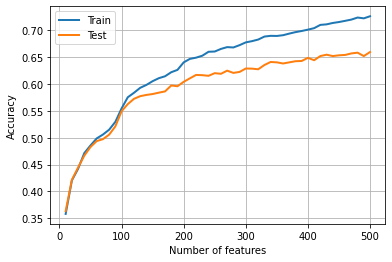

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(top_ns[:len(train_accuracies)], train_accuracies, linewidth=2.0, label='Train')
ax.plot(top_ns[:len(test_accuracies)], test_accuracies, linewidth=2.0, label='Test')
ax_set_title("Logistic regression with feature selection via random forest")
ax.set_xlabel("Number of features")
ax.set_ylabel("Accuracy")
ax.legend()
ax.grid()
fig.show()

---
## Experiment \#6: Logistic regression with feature selection via Select K Best

In [ ]:
"""
Use select K best to select top n features
"""
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

top_ns = np.arange(10, 510, 10)
train_accuracies = []
test_accuracies = []

for top_n in top_ns:

  mask_selected_features = np.full((X_train.shape[1], ), False)
  for i in np.unique(y_train):
    skb = SelectKBest(k=top_n)
    mask = y_train == i
    skb.fit(X_train[mask, :], y_train[mask])
    mask_selected_features |= skb.get_support()
    
  X_train_skb = X_train[:, mask_selected_features]
  X_test_skb = X_test[:, mask_selected_features]

  clf = LogisticRegression(max_iter=10000, class_weight='balanced')
  clf.fit(X_train_skb, y_train)

  train_accuracy = accuracy_score(y_train, clf.predict(X_train_skb))
  train_accuracies.append(train_accuracy)
  test_accuracy = accuracy_score(y_test, clf.predict(X_test_skb))
  test_accuracies.append(test_accuracy)

  print(F"Using the top {top_n} features from select k best...")
  print(F"Train accuracy: {train_accuracy}")
  print(F"Test accuracy:  {test_accuracy}")
  print(F"-"*100)

  # if train_accuracy > test_accuracy:
  #   print(F"Overfitting detected! Stopping training.")
  #   break

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 10 features from select k best...
Train accuracy: 0.32968384074941454
Test accuracy:  0.3341137906813393
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 20 features from select k best...
Train accuracy: 0.40491803278688526
Test accuracy:  0.41863732147038163
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 30 features from select k best...
Train accuracy: 0.4319086651053864
Test accuracy:  0.4392413954577382
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 40 features from select k best...
Train accuracy: 0.46311475409836067
Test accuracy:  0.4612502926715055
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 50 features from select k best...
Train accuracy: 0.4802693208430913
Test accuracy:  0.47763989697963005
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 60 features from select k best...
Train accuracy: 0.5042740046838408
Test accuracy:  0.49730742214937956
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 70 features from select k best...
Train accuracy: 0.5200234192037471
Test accuracy:  0.512760477639897
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 80 features from select k best...
Train accuracy: 0.5332552693208431
Test accuracy:  0.5207211425895575
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 90 features from select k best...
Train accuracy: 0.5379391100702576
Test accuracy:  0.524467337859986
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 100 features from select k best...
Train accuracy: 0.547423887587822
Test accuracy:  0.5331304144228518
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 110 features from select k best...
Train accuracy: 0.5533957845433255
Test accuracy:  0.5335986888316554
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 120 features from select k best...
Train accuracy: 0.5586065573770492
Test accuracy:  0.5431983142121283
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 130 features from select k best...
Train accuracy: 0.5680913348946136
Test accuracy:  0.5502224303441817
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 140 features from select k best...
Train accuracy: 0.5704332552693209
Test accuracy:  0.5492858815265745
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 150 features from select k best...
Train accuracy: 0.5790983606557377
Test accuracy:  0.5497541559353781
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 160 features from select k best...
Train accuracy: 0.5845433255269321
Test accuracy:  0.5535003512058067
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 170 features from select k best...
Train accuracy: 0.5884074941451991
Test accuracy:  0.5523296651837977
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 180 features from select k best...
Train accuracy: 0.5943793911007026
Test accuracy:  0.5614610161554671
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 190 features from select k best...
Train accuracy: 0.5984777517564402
Test accuracy:  0.5645047998126902
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 200 features from select k best...
Train accuracy: 0.6024590163934426
Test accuracy:  0.56052446733786
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 210 features from select k best...
Train accuracy: 0.6063817330210772
Test accuracy:  0.5659096230391009
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 220 features from select k best...
Train accuracy: 0.610655737704918
Test accuracy:  0.5638023881994849
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 230 features from select k best...
Train accuracy: 0.6165690866510538
Test accuracy:  0.5736361507843596
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 240 features from select k best...
Train accuracy: 0.619320843091335
Test accuracy:  0.5726996019667525
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 250 features from select k best...
Train accuracy: 0.6218384074941452
Test accuracy:  0.5708265043315383
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 260 features from select k best...
Train accuracy: 0.6276346604215457
Test accuracy:  0.5748068368063686
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 270 features from select k best...
Train accuracy: 0.6313231850117096
Test accuracy:  0.5750409740107703
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 280 features from select k best...
Train accuracy: 0.6353044496487119
Test accuracy:  0.576445797237181
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 290 features from select k best...
Train accuracy: 0.6374121779859485
Test accuracy:  0.5820650901428237
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 300 features from select k best...
Train accuracy: 0.6460187353629977
Test accuracy:  0.5830016389604308
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 310 features from select k best...
Train accuracy: 0.6470725995316159
Test accuracy:  0.584874736595645
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 320 features from select k best...
Train accuracy: 0.6505269320843091
Test accuracy:  0.5900257550924842
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 330 features from select k best...
Train accuracy: 0.6536299765807962
Test accuracy:  0.5926012643409038
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 340 features from select k best...
Train accuracy: 0.6556791569086651
Test accuracy:  0.594474361976118
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 350 features from select k best...
Train accuracy: 0.6585480093676815
Test accuracy:  0.5914305783188949
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 360 features from select k best...
Train accuracy: 0.6626463700234192
Test accuracy:  0.5926012643409038
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 370 features from select k best...
Train accuracy: 0.6653395784543326
Test accuracy:  0.5961133224069305
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 380 features from select k best...
Train accuracy: 0.6689695550351288
Test accuracy:  0.5975181456333412
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 390 features from select k best...
Train accuracy: 0.6725409836065573
Test accuracy:  0.5989229688597518
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 400 features from select k best...
Train accuracy: 0.6754683840749415
Test accuracy:  0.6014984781081714
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 410 features from select k best...
Train accuracy: 0.6781030444964872
Test accuracy:  0.606181222196207
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 420 features from select k best...
Train accuracy: 0.6820843091334895
Test accuracy:  0.6071177710138141
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 430 features from select k best...
Train accuracy: 0.6839578454332552
Test accuracy:  0.6110981034886444
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 440 features from select k best...
Train accuracy: 0.686943793911007
Test accuracy:  0.6099274174666355
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 450 features from select k best...
Train accuracy: 0.6934426229508197
Test accuracy:  0.6150784359634746
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 460 features from select k best...
Train accuracy: 0.6956088992974239
Test accuracy:  0.6160149847810817
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 470 features from select k best...
Train accuracy: 0.6959016393442623
Test accuracy:  0.6195270428471084
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 480 features from select k best...
Train accuracy: 0.6985948477751757
Test accuracy:  0.6164832591898852
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 490 features from select k best...
Train accuracy: 0.7026346604215457
Test accuracy:  0.6169515335986888
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Using the top 500 features from select k best...
Train accuracy: 0.7039227166276346
Test accuracy:  0.6150784359634746
----------------------------------------------------------------------------------------------------


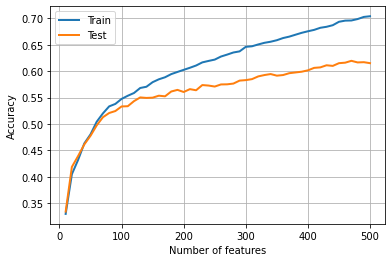

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(top_ns[:len(train_accuracies)], train_accuracies, linewidth=2.0, label='Train')
ax.plot(top_ns[:len(test_accuracies)], test_accuracies, linewidth=2.0, label='Test')
ax.set_title("Logistic regression with feature selection via select k best")
ax.set_xlabel("Number of features")
ax.set_ylabel("Accuracy")
ax.legend()
ax.grid()
fig.show()



---

# Logistic regression with dimensionality reduction

## Experiment \#7: Logistic regression with PCA

In [ ]:
"""
Use PCA to perform dimensionality reduction
"""

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

n_components_list = np.arange(10, 510, 10)
train_accuracies = []
test_accuracies = []

for n_components in n_components_list:

  pca = PCA(n_components)
  X_train_pca = pca.fit_transform(X_train)
  X_test_pca = pca.transform(X_test)

  clf = LogisticRegression(max_iter=10000, class_weight='balanced')
  clf.fit(X_train_pca, y_train)

  train_accuracy = accuracy_score(y_train, clf.predict(X_train_pca))
  train_accuracies.append(train_accuracy)
  test_accuracy = accuracy_score(y_test, clf.predict(X_test_pca))
  test_accuracies.append(test_accuracy)

  print(F"Using {n_components} components from PCA...")
  print(F"Train accuracy: {train_accuracy}")
  print(F"Test accuracy:  {test_accuracy}")
  print(F"-"*100)

  # if train_accuracy > test_accuracy:
  #   print(F"Overfitting detected! Stopping training.")
  #   break

Using 10 components from PCA...
Train accuracy: 0.42213114754098363
Test accuracy:  0.4282369468508546
----------------------------------------------------------------------------------------------------
Using 20 components from PCA...
Train accuracy: 0.4467798594847775
Test accuracy:  0.4579723718098806
----------------------------------------------------------------------------------------------------
Using 30 components from PCA...
Train accuracy: 0.4757025761124122
Test accuracy:  0.4811519550456568
----------------------------------------------------------------------------------------------------
Using 40 components from PCA...
Train accuracy: 0.4959016393442623
Test accuracy:  0.4980098337625849
----------------------------------------------------------------------------------------------------
Using 50 components from PCA...
Train accuracy: 0.5189695550351288
Test accuracy:  0.5186139077499414
-------------------------------------------------------------------------------------

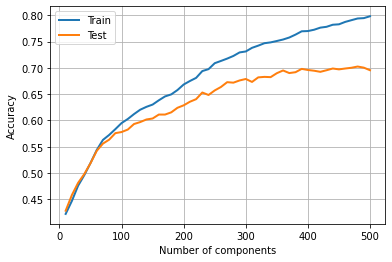

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(n_components_list[:len(train_accuracies)], train_accuracies, linewidth=2.0, label='Train')
ax.plot(n_components_list[:len(test_accuracies)], test_accuracies, linewidth=2.0, label='Test')
ax.set_title("Logistic regression with dimensionality reduction via PCA")
ax.set_xlabel("Number of components")
ax.set_ylabel("Accuracy")
ax.legend()
ax.grid()
fig.show()

## Experiment \#8: Logistic regression with kernel PCA

In [6]:
"""
Use kernel PCA to perform dimensionality reduction
"""
from sklearn.decomposition import KernelPCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

tolerance = 10
n_components_list = np.arange(50, 2050, 50)
train_accuracies = []
test_accuracies = []

for n_components in n_components_list:

  kpca = KernelPCA(n_components=n_components, 
                   kernel='rbf', 
                   n_jobs=-1, 
                   random_state=10,
                   eigen_solver="randomized")
  X_train_kpca = kpca.fit_transform(X_train)
  X_test_kpca = kpca.transform(X_test)

  clf = LogisticRegression(max_iter=10000, class_weight='balanced')
  clf.fit(X_train_kpca, y_train)

  train_accuracy = accuracy_score(y_train, clf.predict(X_train_kpca))
  train_accuracies.append(train_accuracy)
  test_accuracy = accuracy_score(y_test, clf.predict(X_test_kpca))
  test_accuracies.append(test_accuracy)

  print(F"Using {n_components} components from kernel PCA...")
  print(F"Train accuracy: {train_accuracy}")
  print(F"Test accuracy:  {test_accuracy}")
  if train_accuracy > (test_accuracy+0.05):
    print(F"Overfitting detected!")
    if tolerance == 0:
      break
    tolerance -= 1
  else:
    tolerance = 10
  print(F"-"*100)

Using 50 components from kernel PCA...
Train accuracy: 0.5454918032786885
Test accuracy:  0.5439007258253337
----------------------------------------------------------------------------------------------------
Using 100 components from kernel PCA...
Train accuracy: 0.5889344262295082
Test accuracy:  0.5851088738000468
----------------------------------------------------------------------------------------------------
Using 150 components from kernel PCA...
Train accuracy: 0.6153981264637002
Test accuracy:  0.6075860454226176
----------------------------------------------------------------------------------------------------
Using 200 components from kernel PCA...
Train accuracy: 0.6383489461358314
Test accuracy:  0.6253804729571529
----------------------------------------------------------------------------------------------------
Using 250 components from kernel PCA...
Train accuracy: 0.6526346604215457
Test accuracy:  0.6387262936080543
-----------------------------------------------

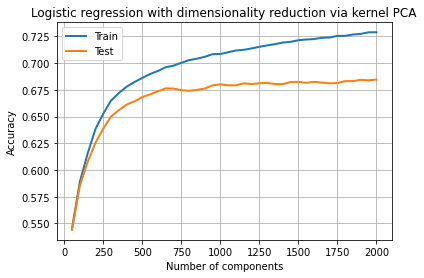

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(n_components_list[:len(train_accuracies)], train_accuracies, linewidth=2.0, label='Train')
ax.plot(n_components_list[:len(test_accuracies)], test_accuracies, linewidth=2.0, label='Test')
ax.set_title("Logistic regression with dimensionality reduction via kernel PCA")
ax.set_xlabel("Number of components")
ax.set_ylabel("Accuracy")
ax.legend()
ax.grid()
fig.show()

## Experiment \#9: Logistic regression with kernel PCA + L1 penalty

In [ ]:
"""
Use kernel PCA to perform dimensionality reduction
"""

from sklearn.decomposition import KernelPCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

tolerance = 10
n_components_list = np.arange(10, 510, 10)
train_accuracies = []
test_accuracies = []

for n_components in n_components_list:

  kpca = KernelPCA(n_components=n_components, 
                   kernel='rbf', 
                   n_jobs=-1, 
                   random_state=10,
                   eigen_solver="randomized")
  X_train_kpca = kpca.fit_transform(X_train)
  X_test_kpca = kpca.transform(X_test)

  clf = LogisticRegression(max_iter=100000, 
                           class_weight='balanced', 
                           solver='saga', 
                           penalty='l1')
  clf.fit(X_train_kpca, y_train)

  train_accuracy = accuracy_score(y_train, clf.predict(X_train_kpca))
  train_accuracies.append(train_accuracy)
  test_accuracy = accuracy_score(y_test, clf.predict(X_test_kpca))
  test_accuracies.append(test_accuracy)

  print(F"Using {n_components} components from kernel PCA (l1)...")
  print(F"Train accuracy: {train_accuracy}")
  print(F"Test accuracy:  {test_accuracy}")
  if train_accuracy > (test_accuracy+0.05):
    print(F"Overfitting detected!")
    if tolerance == 0:
      break
    tolerance -= 1
  else:
    tolerance = 10
  print(F"-"*100)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Using 10 components from kernel PCA (l1)...
Train accuracy: 0.42745901639344264
Test accuracy:  0.4432217279325685
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Using 20 components from kernel PCA (l1)...
Train accuracy: 0.4772248243559719
Test accuracy:  0.48208850386326385
----------------------------------------------------------------------------------------------------
Using 30 components from kernel PCA (l1)...
Train accuracy: 0.4997658079625293
Test accuracy:  0.5001170686022008
----------------------------------------------------------------------------------------------------
Using 40 components from kernel PCA (l1)...
Train accuracy: 0.5335480093676815
Test accuracy:  0.5247014750643877
----------------------------------------------------------------------------------------------------
Using 50 components from kernel PCA (l1)...
Train accuracy: 0.5498243559718969
Test accuracy:  0.5420276281901194
----------------------------------------------------------------------------------------------------
Using 60 components from kernel PCA (l1)...
Train accuracy: 0.5625292740046839
Test accuracy:  0.5492858815265745
-------------------------

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(n_components_list[:len(train_accuracies)], train_accuracies, linewidth=2.0, label='Train')
ax.plot(n_components_list[:len(test_accuracies)], test_accuracies, linewidth=2.0, label='Test')
ax.set_title("Logistic regression (l1) with dimensionality reduction via kernel PCA")
ax.set_xlabel("Number of components")
ax.set_ylabel("Accuracy")
ax.legend()
ax.grid()
fig.show()